In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

pd.set_option("display.max_columns", 200)


In [3]:
TARGET_COLS = ["real_weight", "real_height", "real_length", "real_width"]
OUTPUT_COLS = ["weight", "height", "length", "width"]

SAMPLE_ROWS = None
VALID_SIZE = 0.2
RANDOM_STATE = 42


In [4]:
def log_mae_per_target(y_true: np.ndarray, y_pred: np.ndarray):
    y_true = np.nan_to_num(y_true, nan=0.0)
    y_pred = np.nan_to_num(y_pred, nan=0.0)
    y_true = np.maximum(y_true, 0.0)
    y_pred = np.maximum(y_pred, 0.0)

    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    per_target = np.mean(np.abs(log_true - log_pred), axis=0)
    return dict(zip(TARGET_COLS, per_target))


def macro_log_mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(list(log_mae_per_target(y_true, y_pred).values())))


In [5]:
train_df = pd.read_parquet("train.parquet")
test_df = pd.read_parquet("test.parquet")

if SAMPLE_ROWS is not None and len(train_df) > SAMPLE_ROWS:
    train_df = train_df.sample(SAMPLE_ROWS, random_state=RANDOM_STATE).reset_index(drop=True)

print("train shape:", train_df.shape)
print("test shape:", test_df.shape)


train shape: (312908, 16)
test shape: (70274, 12)


## данные


In [6]:
overview = pd.DataFrame(
    {
        "rows": [len(train_df), len(test_df)],
        "cols": [train_df.shape[1], test_df.shape[1]],
        "numeric_cols": [len(train_df.select_dtypes(include=[np.number]).columns), len(test_df.select_dtypes(include=[np.number]).columns)],
        "object_cols": [len(train_df.select_dtypes(include=["object"]).columns), len(test_df.select_dtypes(include=["object"]).columns)],
    },
    index=["train", "test"],
)
overview


,rows,cols,numeric_cols,object_cols
train,312908,16,8,8
test,70274,12,4,8


In [7]:
missing_share = train_df.isna().mean().sort_values(ascending=False)
missing_top = missing_share[missing_share > 0].head(20).to_frame("missing_share")
missing_top


,missing_share
item_condition,0.052073


распределения таргетов


In [8]:
target_stats = train_df[TARGET_COLS].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
target_stats["skew"] = train_df[TARGET_COLS].skew()
target_stats


,count,mean,std,min,1%,5%,50%,95%,99%,max,skew
real_weight,312908.0,1.691869,19.957223,0.001,0.019,0.1,0.69,6.0,14.3,7090.0,226.097963
real_height,312908.0,11.614749,8.325673,1.000,1.000,1.0,10.00,29.0,36.0,288.0,1.468822
real_length,312908.0,33.134321,204.112738,1.000,7.000,10.0,32.00,56.0,99.0,111363.0,522.597138
real_width,312908.0,23.491592,22.442816,1.000,4.000,10.0,22.00,44.0,52.0,11029.0,377.016515


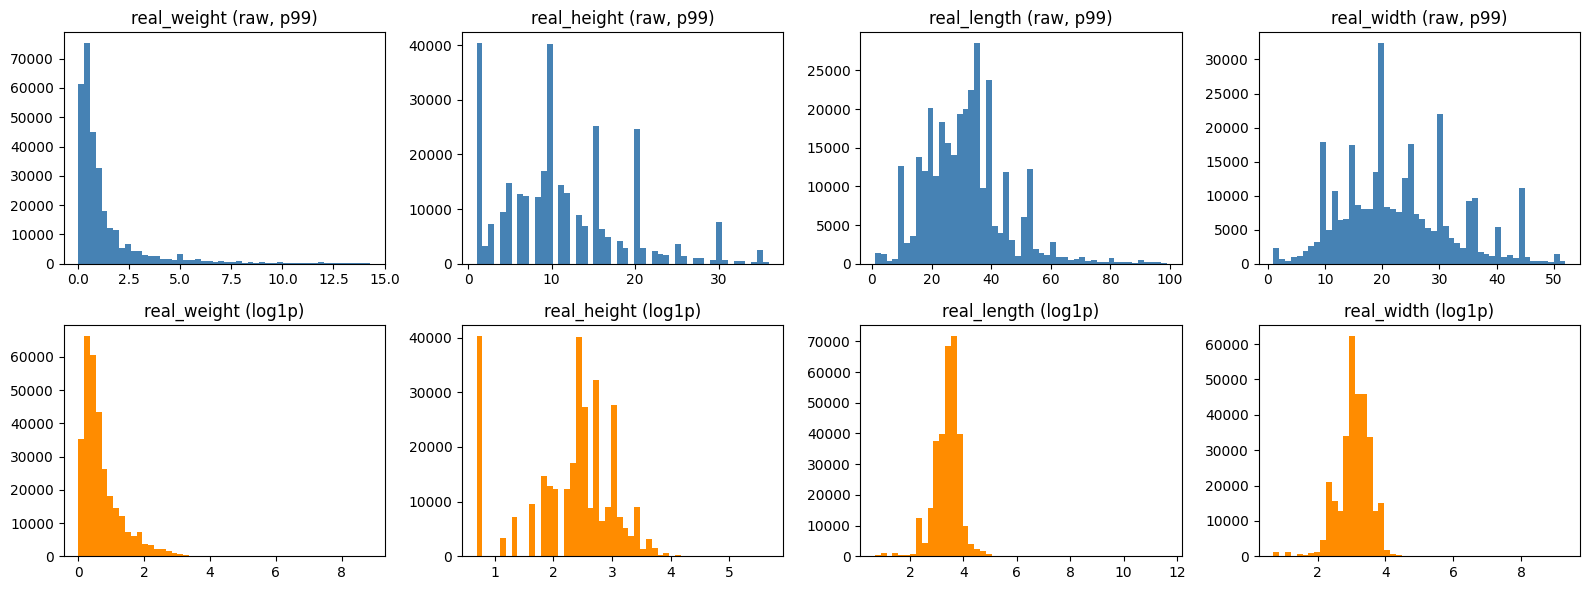

In [9]:
fig, axes = plt.subplots(2, len(TARGET_COLS), figsize=(4 * len(TARGET_COLS), 6))

for i, col in enumerate(TARGET_COLS):
    raw = train_df[col].clip(lower=0)
    raw_cut = raw[raw <= raw.quantile(0.99)]

    axes[0, i].hist(raw_cut, bins=50, color="steelblue")
    axes[0, i].set_title(f"{col} (raw, p99)")

    axes[1, i].hist(np.log1p(raw), bins=50, color="darkorange")
    axes[1, i].set_title(f"{col} (log1p)")

plt.tight_layout()


In [10]:
category_levels = train_df[["category_name", "subcategory_name", "microcat_name"]].nunique()
category_levels


category_name         5
subcategory_name     25
microcat_name       359
dtype: int64

In [11]:
category_profile = (
    train_df.groupby("category_name")
    .agg(
        n=("item_id", "count"),
        median_price=("item_price", "median"),
        median_weight=("real_weight", "median"),
        median_height=("real_height", "median"),
        median_length=("real_length", "median"),
        median_width=("real_width", "median"),
    )
    .sort_values("n", ascending=False)
)
category_profile.head(15)


,n,median_price,median_weight,median_height,median_length,median_width
category_name,,,,,,
Личные вещи,173687,900.0,0.57,10.0,32.0,22.0
Электроника,44450,2000.0,0.80,10.0,28.0,20.0
Транспорт,37545,2000.0,1.23,12.0,33.0,20.0
Хобби и отдых,34160,850.0,0.76,10.0,30.0,21.0
Для дома и дачи,23066,1000.0,1.41,14.0,35.0,24.0


важны ли категориальные признаки?

In [12]:
signal_df = train_df[["category_name"] + TARGET_COLS].copy()

train_sig, valid_sig = train_test_split(
    signal_df,
    test_size=VALID_SIZE,
    random_state=RANDOM_STATE
)

# Считаем медиану каждого таргета по всему train
global_median = train_sig[TARGET_COLS].median().to_numpy(dtype=np.float32)
global_pred = np.repeat(global_median[None, :], len(valid_sig), axis=0)

global_score = macro_log_mae(
    valid_sig[TARGET_COLS].to_numpy(dtype=np.float32),
    global_pred
)

# Считаем медиану таргетов внутри каждой категории
cat_medians = train_sig.groupby("category_name")[TARGET_COLS].median()
cat_pred_df = valid_sig[["category_name"]].join(
    cat_medians,
    on="category_name"
)

for i, col in enumerate(TARGET_COLS):
    cat_pred_df[col] = cat_pred_df[col].fillna(global_median[i])

cat_pred = cat_pred_df[TARGET_COLS].to_numpy(dtype=np.float32)

cat_score = macro_log_mae(
    valid_sig[TARGET_COLS].to_numpy(dtype=np.float32),
    cat_pred
)

pd.DataFrame(
    [
        {"baseline": "global_median", "macro_log_mae": global_score},
        {"baseline": "category_median", "macro_log_mae": cat_score},
    ]
)


,baseline,macro_log_mae
0,global_median,0.428610
1,category_median,0.422803


влияние цены на размеры и вес

In [13]:
price_eda = train_df[["item_price"] + TARGET_COLS].copy()
price_eda["item_price"] = pd.to_numeric(price_eda["item_price"], errors="coerce").fillna(0.0).clip(lower=0.0)
price_eda["price_bin"] = pd.qcut(price_eda["item_price"], q=10, duplicates="drop")

price_profile = (
    price_eda.groupby("price_bin")
    .agg(
        n=("item_price", "count"),
        median_price=("item_price", "median"),
        median_weight=("real_weight", "median"),
        median_height=("real_height", "median"),
        median_length=("real_length", "median"),
        median_width=("real_width", "median"),
    )
)
price_profile


/var/folders/k1/6sdhw1_x4b792ywcdxrsbk6w0000gn/T/ipykernel_10549/1613514763.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_eda.groupby("price_bin")


,n,median_price,median_weight,median_height,median_length,median_width
price_bin,,,,,,
"(0.999, 255.0]",31339,150.0,0.480,9.0,28.0,20.0
"(255.0, 430.0]",31370,350.0,0.420,8.0,27.0,20.0
"(430.0, 550.0]",33252,500.0,0.500,9.0,30.0,20.0
"(550.0, 800.0]",33091,700.0,0.530,10.0,30.0,20.0
"(800.0, 1000.0]",29591,1000.0,0.640,10.0,31.0,22.0
"(1000.0, 1500.0]",35635,1300.0,0.680,10.0,32.0,22.0
"(1500.0, 2100.0]",25760,1950.0,0.770,10.0,33.0,23.0
"(2100.0, 3440.0]",30290,2700.0,0.850,11.0,33.0,23.0
"(3440.0, 6250.0]",31304,4500.0,1.055,12.0,35.0,24.0


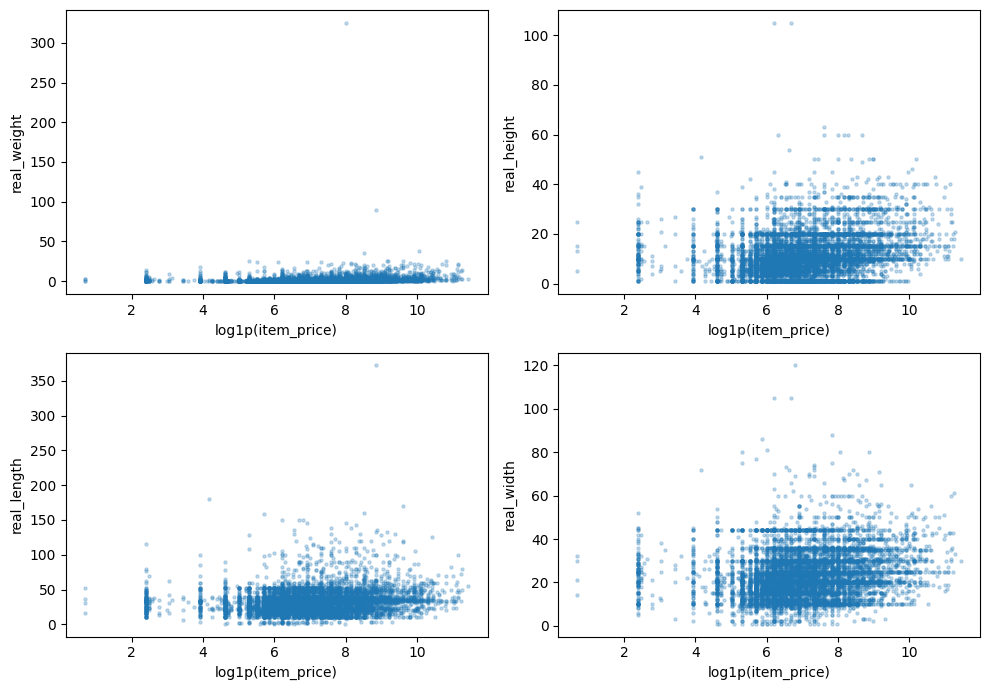

In [14]:
sample = train_df.sample(min(8000, len(train_df)), random_state=RANDOM_STATE)
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.ravel()

x = np.log1p(pd.to_numeric(sample["item_price"], errors="coerce").fillna(0.0).clip(lower=0.0))
for i, col in enumerate(TARGET_COLS):
    y = sample[col].clip(lower=0)
    axes[i].scatter(x, y, s=5, alpha=0.25)
    axes[i].set_xlabel("log1p(item_price)")
    axes[i].set_ylabel(col)

plt.tight_layout()


In [15]:
# Простая корреляция числовых признаков с таргетами
num_eda = pd.DataFrame(index=train_df.index)
num_eda["item_price_log"] = np.log1p(pd.to_numeric(train_df["item_price"], errors="coerce").fillna(0.0).clip(lower=0.0))
num_eda["item_condition"] = pd.to_numeric(train_df["item_condition"], errors="coerce").fillna(0.0)

order_dt = pd.to_datetime(train_df["order_date"], errors="coerce")
num_eda["order_year"] = order_dt.dt.year.fillna(0)
num_eda["order_month"] = order_dt.dt.month.fillna(0)
num_eda["order_dow"] = order_dt.dt.dayofweek.fillna(0)

title = train_df["title"].fillna("").astype(str)
description = train_df["description"].fillna("").astype(str)
num_eda["title_len"] = title.str.len()
num_eda["description_len"] = description.str.len()

corr_table = num_eda.join(train_df[TARGET_COLS]).corr().loc[num_eda.columns, TARGET_COLS]
corr_table


,real_weight,real_height,real_length,real_width
item_price_log,0.033981,0.215189,0.013702,0.078590
item_condition,NaN,NaN,NaN,NaN
order_year,NaN,NaN,NaN,NaN
order_month,0.000738,0.018926,-0.006061,-0.049607
order_dow,-0.001106,-0.009513,-0.002210,-0.001061
title_len,0.001048,0.023296,-0.000531,-0.004353
description_len,0.002925,0.034219,0.001752,0.004828


Чистка данных

In [16]:
NUMERIC_FEATURES = [
    "item_price",
    "item_price_log",
    "item_condition",
    "order_year",
    "order_month",
    "order_day",
    "order_dow",
    "title_len",
    "description_len",
    "title_words",
    "description_words",
    "has_image",
]

CATEGORICAL_FEATURES = [
    "category_name",
    "subcategory_name",
    "microcat_name",
    "seller_id",
    "buyer_id",
]

FEATURE_COLS = NUMERIC_FEATURES + CATEGORICAL_FEATURES


def build_feature_frame(df: pd.DataFrame) -> pd.DataFrame:
    data = pd.DataFrame(index=df.index)

    data["item_price"] = (
        pd.to_numeric(df["item_price"], errors="coerce")
        .fillna(0.0)
        .clip(lower=0.0)
        .astype(np.float32)
    )
    data["item_price_log"] = np.log1p(data["item_price"])
    data["item_condition"] = pd.to_numeric(df["item_condition"], errors="coerce").fillna(0.0).astype(np.float32)

    order_dt = pd.to_datetime(df["order_date"], errors="coerce")
    data["order_year"] = order_dt.dt.year.fillna(0).astype(np.int16)
    data["order_month"] = order_dt.dt.month.fillna(0).astype(np.int8)
    data["order_day"] = order_dt.dt.day.fillna(0).astype(np.int8)
    data["order_dow"] = order_dt.dt.dayofweek.fillna(0).astype(np.int8)

    title = df["title"].fillna("").astype(str)
    description = df["description"].fillna("").astype(str)
    data["title_len"] = title.str.len().astype(np.int32)
    data["description_len"] = description.str.len().astype(np.int32)
    data["title_words"] = title.str.split().str.len().fillna(0).astype(np.int32)
    data["description_words"] = description.str.split().str.len().fillna(0).astype(np.int32)
    data["has_image"] = df["image_name"].notna().astype(np.int8)

    data["category_name"] = df["category_name"].fillna("unknown").astype(str)
    data["subcategory_name"] = df["subcategory_name"].fillna("unknown").astype(str)
    data["microcat_name"] = df["microcat_name"].fillna("unknown").astype(str)
    data["seller_id"] = df["seller_id"].fillna(-1).astype("int64").astype(str)
    data["buyer_id"] = df["buyer_id"].fillna(-1).astype("int64").astype(str)

    return data[FEATURE_COLS]


отсечение выбросов

In [17]:
X = build_feature_frame(train_df)
y = train_df[TARGET_COLS].to_numpy(dtype=np.float32)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=RANDOM_STATE
)

low_q = np.quantile(y_train, 0.01, axis=0)
high_q = np.quantile(y_train, 0.99, axis=0)
inlier_mask = ((y_train >= low_q) & (y_train <= high_q)).all(axis=1)

X_train = X_train.iloc[inlier_mask].copy()
y_train = y_train[inlier_mask]

print("n_features:", len(FEATURE_COLS))
print("train split:", X_train.shape, y_train.shape)
print("valid split:", X_valid.shape, y_valid.shape)
print("outliers removed from train:", int((~inlier_mask).sum()))


n_features: 17
train split: (237789, 17) (237789, 4)
valid split: (62582, 17) (62582, 4)
outliers removed from train: 12537


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", NUMERIC_FEATURES),
        (
            "cat",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            CATEGORICAL_FEATURES,
        ),
    ]
)

models = [
    ("DummyRegressor", DummyRegressor(strategy="mean")),
    ("Ridge", Ridge(alpha=1.0)),
    (
        "RandomForest",
        RandomForestRegressor(
            n_estimators=180,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            min_samples_leaf=2,
        ),
    ),
    (
        "ExtraTrees",
        ExtraTreesRegressor(
            n_estimators=260,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            min_samples_leaf=2,
        ),
    ),
]

results = []
for model_name, model in models:
    pipe = Pipeline(
        steps=[
            ("preprocess", clone(preprocessor)),
            ("model", clone(model)),
        ]
    )

    pipe.fit(X_train, y_train)
    valid_pred = np.maximum(pipe.predict(X_valid), 0.0)

    results.append(
        {
            "model": model_name,
            "macro_log_mae": macro_log_mae(y_valid, valid_pred),
        }
    )

results_df = pd.DataFrame(results).sort_values("macro_log_mae").reset_index(drop=True)
results_df


In [ ]:
best_model_name = results_df.iloc[0]["model"]
best_model = next(model for model_name, model in models if model_name == best_model_name)

print("Best model:", best_model_name)
print(f"Best validation Macro Log-MAE: {results_df.iloc[0]['macro_log_mae']:.6f}")

final_model = Pipeline(
    steps=[
        ("preprocess", clone(preprocessor)),
        ("model", clone(best_model)),
    ]
)

X_full = build_feature_frame(train_df)
y_full = train_df[TARGET_COLS].to_numpy(dtype=np.float32)

low_q_full = np.quantile(y_full, 0.01, axis=0)
high_q_full = np.quantile(y_full, 0.99, axis=0)
inlier_mask_full = ((y_full >= low_q_full) & (y_full <= high_q_full)).all(axis=1)

X_full = X_full.iloc[inlier_mask_full].copy()
y_full = y_full[inlier_mask_full]
final_model.fit(X_full, y_full)

X_test = build_feature_frame(test_df)
test_pred = np.maximum(final_model.predict(X_test), 0.0)

submission = pd.DataFrame(test_pred, columns=OUTPUT_COLS)
submission.insert(0, "item_id", test_df["item_id"].values)
submission.head()


NameError: name 'results_df' is not defined

In [ ]:
# submission.to_csv("result.csv", index=False)
